In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Using Visibility Graphs to Estimate the Hurst Parameter 

In [10]:
# dict for formatting in references 
# todo copy/paste these into cells
refs = {'lacasa2009':'[Lacasa et al. 2009](https://www.readcube.com/library/ee993268-97d7-4f91-b728-eb1b1ac33f55:f660b4a6-9d04-463a-a31a-dd4a196baeae)'}

In this notebook, we have been introduced to the visibility graph and how such graphs can translate a time series into a network. Also, we have introduced the concept of long memory in time series and how this property can be measured with the Hurst parameter $H$. We have also used the `fbm` codebase to generate time series with different values of $H$. 

In {{refs['lacasa2009']}}, the authors introduce that visibility graphs can be used to esimate the Hurst parameter. In this section, we will replicate these results in Python.

The {{refs['lacasa2009']}} paper shows that the degree distribution of a visibility graph follows a power law, and that the exponent of the degree distribution approximates the Hurst parameter. 

To begin to explore this idea, we can generate FBM series that have different Hurst parameters and plot histograms of the corresponding visibility graphs. We'll use the same `fbm` project introduced earlier, the `build_visibility_graph` module and we will use `networkx` to create graph objects:

In [12]:
from src.fbm.fbm import FBM
from src import build_visibility_graph 
import networkx as nx

Now, we can generate three different FBM series with Hurst parameters 0.25, 0.5 and 0.75:

In [38]:
%%time
graphs = dict()
n = 1000

for hurst in [0.25, 0.5, 0.75]:
    y = FBM(n=n, hurst=hurst, length=1, method='daviesharte').fbm()
    x = list(range(len(y)))
    edges = build_visibility_graph.create_edges(x, y)
    graphs[hurst] = nx.from_edgelist(edges)

CPU times: user 31.7 s, sys: 7.97 ms, total: 31.7 s
Wall time: 31.7 s


Now we have a dict `graphs` with keys that are Hurst parameters and values that are time series with the same Hurst parameter. 

We now build a similar dictionary `degs`, where the values are instead arrays of node degrees:

In [39]:
get_degs = lambda g: [g.degree(x) for x in g.nodes]
degs = {k:get_degs(v) for k,v in graphs.items()}

...and create a simple histogram:

In [120]:
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def interact_plot(log=False, h25=True, h50=True, h75=True):
    """Creates histogram of three different degree distributions"""
    global degs
    # create base figure and axis
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    
    # setup data for histogram
    # subset node degree lists based on input args "hxx", i.e. checkboxes
    y = [degs[x] for x, inc_bool in zip([0.25, 0.5, 0.75], (h25, h50, h75)) 
         if inc_bool == True]
    # create labels for legend based on checkboxes
    labs = [x for x, inc_bool in zip([0.25, 0.5, 0.75], (h25, h50, h75)) 
            if inc_bool]
    
    # fix the colors to keep consistent across different selections
    colors = {0.25:'#31393C', 0.5:'#0070AF', 0.75:'#A31621'}
    # add the histogram
    bins = np.linspace(0,140,28)
    ax.hist(y, bins, label=labs, log=log, color=[colors[x] for x in labs])
    
    # format various aesthetics and labels
    t = 'Histogram of Node Degree for Visibility Graphs by Hurst Parameter H'
    yl = 'Number of Nodes'; ylab = f'log({yl})' if log else yl
    ax.set(title=t, xlabel='Node Degree', ylabel=ylab)
    ax.xaxis.set(ticks=range(0,145,5))
    ax.legend()
    ax.grid()

interactive(children=(Checkbox(value=False, description='log'), Checkbox(value=True, description='h25'), Check…

The checkboxes can be used to toggle whether or not the y-axis is in log and to select any or all of the three different Hurst parameters 0.25, 0.5 and 0.75. 

By default a simple histogram is plotted, but viewing the histogram in log helps see the difference in the degree distributions:

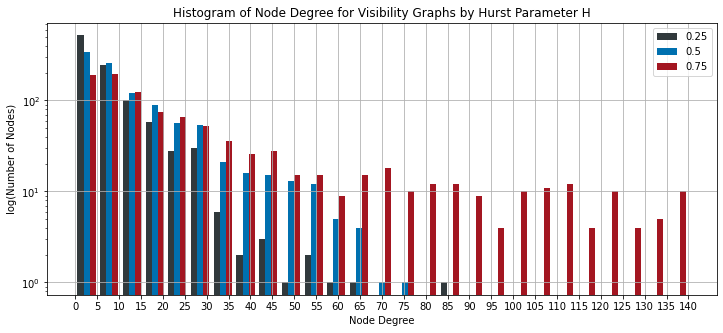

...the persistent series ($H=0.75$, in red above) has many more nodes with degree greater than 75 than does the random series ($H=0.5$, in blue above), and conversely the antipersistent series ($H=0.25$, in black above) has fewer nodes with large degree than does the random series.